## ResNet (TensorFlow Implementation)

In [27]:
'''
This is the ResNet implementation in TensorFlow.
Reference: https://github.com/aladdinpersson/Machine-Learning-Collection/tree/master/ML/TensorFlow/CNN_architectures/ResNet
'''
import tensorflow as tf
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    Activation,
    Add,
    BatchNormalization,
    Input,
    ZeroPadding2D,
    Flatten,
    GlobalAveragePooling2D,
    AveragePooling2D,
    MaxPooling2D
)
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import typing

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

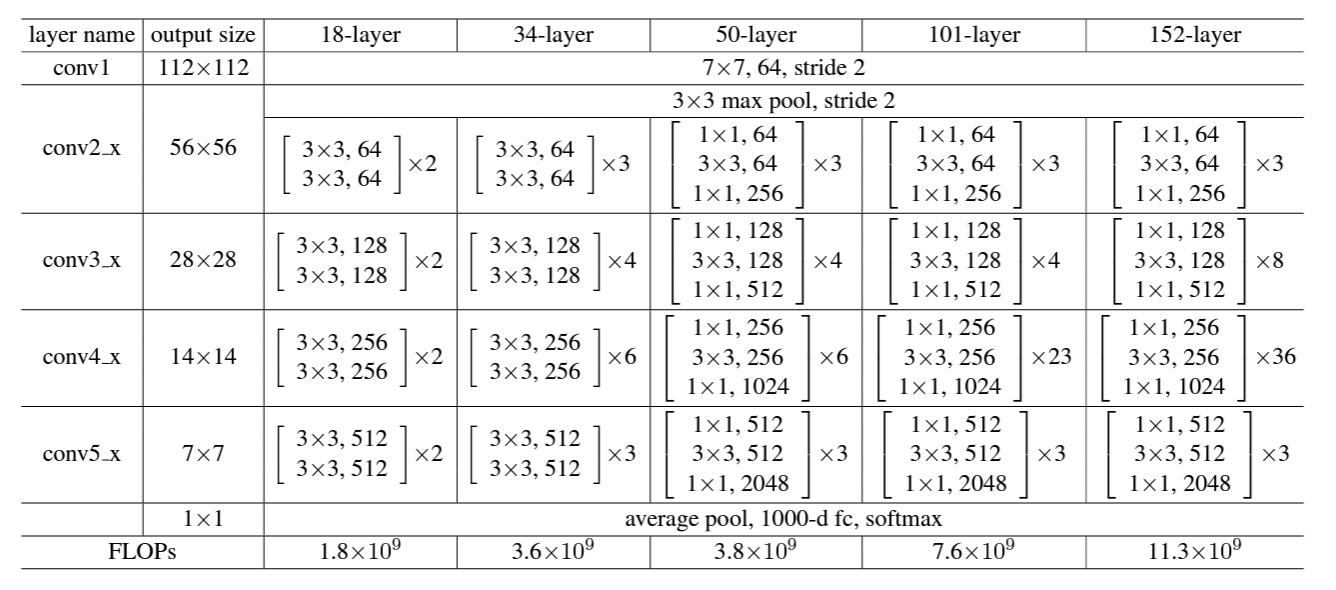

### ResNet18

In [28]:
def residual_block(
    X: tf.Tensor,
    filters: typing.List[int],
    base_name: str,
    downsample: bool) -> tf.Tensor:

    # Filters
    F1, F2 = filters
    x = Conv2D(filters=F1, kernel_size=3, strides=1, padding='same', name=f'{base_name}_a')(X)
    x = BatchNormalization(name=f'bn_{base_name}_a')(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=F2, kernel_size=3, strides=1, padding='same', name=f'{base_name}_b')(x)
    x = BatchNormalization(name=f'bn_{base_name}_b')(x)
    x = Activation('relu')(x)
    if downsample:
        residual = Conv2D(filters=F2, kernel_size=3, strides=1, padding='same', name=f'{base_name}_downsample')(x)
        x = Add()([residual, x])
        x = BatchNormalization(name=f'bn_{base_name}_downsample')(x)
        x = Activation('relu')(x)
    return x

In [29]:
def _make_layer(
    X: tf.Tensor,
    base_name: str,
    filters: typing.List[int],
    layers: int) -> tf.Tensor:
    curr_filters = X.shape[-1]
    t = 0
    if curr_filters != filters[0]:
        X = residual_block(X,
            filters=filters,
            base_name=f'{base_name}_{t}',
            downsample=True)
        t += 1
    else:
        X = residual_block(X,
            filters=filters,
            base_name=f'{base_name}_{t}',
            downsample=False)
        t += 1
    for _ in range(layers - 1):
        X = residual_block(X, base_name=f'{base_name}_{t}', downsample=False, filters=filters)
    return X

In [36]:
def resnet(
    layers: typing.List[int],
    name: str,
    out_classes: int = 1000,
    input_shape: tuple = (224, 224, 3)) -> Model:
    X_input = Input(shape=input_shape)
    print(f'X_input: {X_input.shape}')
    # Conv1
    X = Conv2D(filters=64, kernel_size=3, strides=2, padding='same', name='conv1')(X_input)
    X = BatchNormalization(name="bn_conv1")(X)
    X = Activation('relu')(X)
    print(f'X after Conv1: {X.shape}')
    X = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(X)
    print(f'X after MaxPooling2D: {X.shape}')

    # Conv2
    X = _make_layer(X, base_name='conv2', filters=[64, 64], layers=layers[0])
    print(f'X after Conv2: {X.shape}')

    # Conv3
    X = _make_layer(X, base_name='conv3', filters=[128, 128], layers=layers[0])
    X = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(X)
    print(f'X after Conv3: {X.shape}')

    # Conv4
    X = _make_layer(X, base_name='conv4', filters=[256, 256], layers=layers[0])
    X = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(X)
    print(f'X after Conv4: {X.shape}')

    # Conv5
    X = _make_layer(X, base_name='conv5', filters=[512, 512], layers=layers[0])
    X = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(X)
    print(f'X after Conv5: {X.shape}')

    # Global Average Pooling
    X = GlobalAveragePooling2D()(X)
    print(f'X after GlobalAveragePooling2D: {X.shape}')

    X = Flatten()(X)
    print(f'X after Flatten: {X.shape}')

    X = Dense(units=out_classes, activation='softmax', name='output_layer')(X)
    print(f'Output: {X.shape}')
    
    model = Model(inputs=[X_input], outputs=[X], name=name)
    return model

In [37]:
model = resnet(layers=[2, 2, 2, 2], name='resnet', out_classes=1000, input_shape=(224, 224, 3))

X_input: (None, 224, 224, 3)
X after Conv1: (None, 112, 112, 64)
X after MaxPooling2D: (None, 56, 56, 64)
X after Conv2: (None, 56, 56, 64)
X after Conv3: (None, 28, 28, 128)
X after Conv4: (None, 14, 14, 256)
X after Conv5: (None, 7, 7, 512)
X after GlobalAveragePooling2D: (None, 512)
X after Flatten: (None, 512)
Output: (None, 1000)


In [32]:
model.summary()

Model: "resnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 64  1792        ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 112, 112, 64  256         ['conv1[0][0]']                  
                                )                                                            

 activation_74 (Activation)     (None, 28, 28, 128)  0           ['bn_conv3_1_b[0][0]']           
                                                                                                  
 conv4_0_a (Conv2D)             (None, 28, 28, 256)  295168      ['activation_74[0][0]']          
                                                                                                  
 bn_conv4_0_a (BatchNormalizati  (None, 28, 28, 256)  1024       ['conv4_0_a[0][0]']              
 on)                                                                                              
                                                                                                  
 activation_75 (Activation)     (None, 28, 28, 256)  0           ['bn_conv4_0_a[0][0]']           
                                                                                                  
 conv4_0_b (Conv2D)             (None, 28, 28, 256)  590080      ['activation_75[0][0]']          
          

                                                                                                  
 output_layer (Dense)           (None, 1000)         513000      ['flatten_3[0][0]']              
                                                                                                  
Total params: 14,620,776
Trainable params: 14,611,176
Non-trainable params: 9,600
__________________________________________________________________________________________________


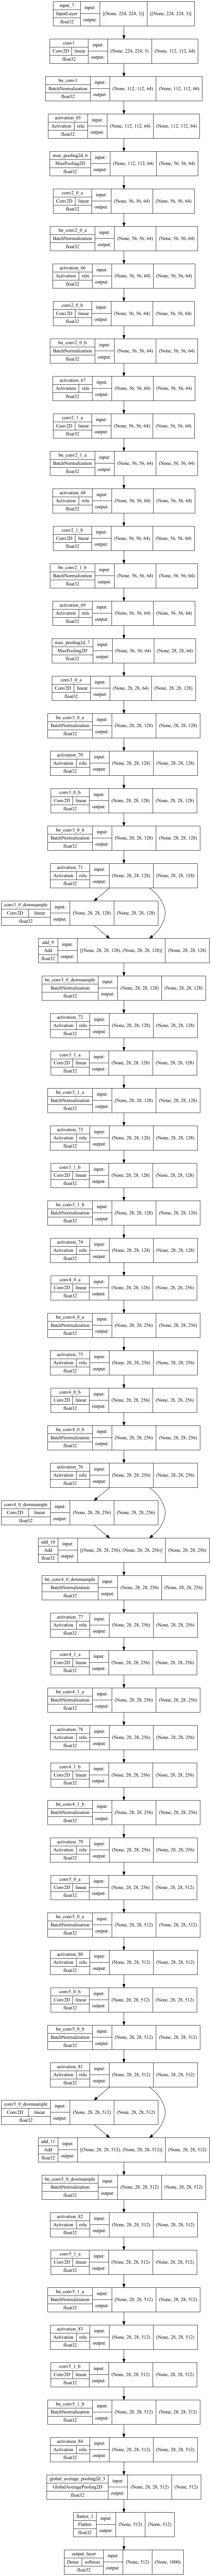

In [33]:
plot_model(model=model, show_shapes=True, show_layer_names=True, show_dtype=True, show_layer_activations=True)